the shape of mesh is torch.Size([3, 2400, 4094]) and the shape of w_cube is torch.Size([3, 2400, 4094])
torch.Size([3, 2400, 4094])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


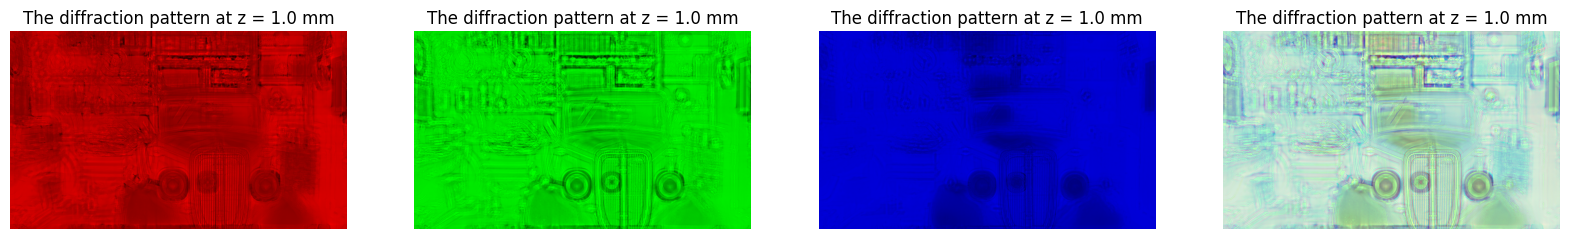

In [23]:
import torch
import math
import matplotlib.pyplot as plt

from PIL import Image
from torchvision import transforms

import utilities

import math
import numpy as np
import torch
import matplotlib.pyplot as plt

import utilities


class bandLimitedAngularSpectrumMethod:
    def __init__(
        self,
        amplitudeTensor=None,
        phaseTensor=None,
        distances=torch.Tensor([0.0]),
        pixel_pitch=3.74e-6,
        wave_length=torch.tensor([639e-9, 515e-9, 473e-9]),
        padding=False,
        debug=False,
        device="cpu",
    ):
        if amplitudeTensor is None:
            self.amplitudeTensor = (
                utilities.amplitude_tensor_generator_for_phase_only_hologram(
                    ".\data\images\sample_hologram.png"
                )
            )
        else:
            self.amplitudeTensor = amplitudeTensor

        if phaseTensor is None:
            self.phaseTensor = utilities.phase_tensor_generator(
                ".\data\images\sample_hologram.png"
            )
        else:
            self.phaseTensor = phaseTensor

        if not isinstance(self.amplitudeTensor, torch.Tensor) or not isinstance(
            self.phaseTensor, torch.Tensor
        ):
            raise ValueError("Amplitude tensor or phase tensor is required")
        if self.amplitudeTensor.shape != self.phaseTensor.shape:
            raise ValueError(
                "Amplitude and phase tensors must have the same shape, but got {} and {}.".format(
                    self.amplitudeTensor.shape, self.phaseTensor.shape
                )
            )

        self.distances = distances
        self.pixel_pitch = pixel_pitch
        self.wave_length = wave_length

        self.samplingRowNum = self.phaseTensor.shape[-2]
        self.samplingColNum = self.phaseTensor.shape[-1]

        self.padding = padding
        self.debug = debug

        if device == "cuda":
            device = utilities.try_gpu()
        self.device = device

    def frequencyMesh(self):
        # generate the 2-D frequency mesh
        self.freq_x = torch.fft.fftfreq(self.samplingRowNum, self.pixel_pitch)
        self.freq_y = torch.fft.fftfreq(self.samplingColNum, self.pixel_pitch)

        mesh_x_y = self.freq_x.unsqueeze(1) ** 2 + self.freq_y.unsqueeze(0) ** 2
        mesh_wave_length = 1 / self.wave_length**2
        mesh = torch.sqrt(
            torch.clamp(
                mesh_wave_length.unsqueeze(1).unsqueeze(2) - mesh_x_y.unsqueeze(0),
                min=0,
            )
        )

        if self.debug:
            print(
                "The highest positive frequency is u = {} and v = {}.".format(
                    self.freq_x.max(), self.freq_y.max()
                )
            )
            print(
                "The highest negative frequency is u = {} and v = {}.".format(
                    self.freq_x.min(), self.freq_y.min()
                )
            )
            print(
                "The resolution of the frequency is u = {} and v = {}.".format(
                    self.freq_x[1] - self.freq_x[0], self.freq_y[1] - self.freq_y[0]
                )
            )

        return mesh

    def band_limited_mask(self):

        S_height = (
            self.samplingRowNum * self.pixel_pitch
        )  # the height of the sampling plain
        S_width = (
            self.samplingColNum * self.pixel_pitch
        )  # the width of the sampling plain

        d_u = 1 / S_height
        d_v = 1 / S_width

        wave_length = self.wave_length.unsqueeze(0)
        distances = self.distances.unsqueeze(1)

        u_limit = 1 / (
            math.sqrt((2 * d_u * distances) ** 2 + 1) * wave_length
        )
        v_limit = 1 / (
            math.sqrt((2 * d_v * distances) ** 2 + 1) * wave_length
        )
        mask_u = torch.abs(self.freq_x).unsqueeze(0).unsqueeze(1).unsqueeze(
            3
        ) < u_limit.unsqueeze(2).unsqueeze(3)
        mask_v = torch.abs(self.freq_y).unsqueeze(0).unsqueeze(1).unsqueeze(
            2
        ) < v_limit.unsqueeze(2).unsqueeze(3)

        mask = mask_u & mask_v

        if self.debug:
            print(
                "The maximum frequency is clipped to u = {} and v = {}.".format(
                    u_limit, v_limit
                )
            )

        return mask

    def band_limited_angular_spectrum_multichannels(
        self,
        band_limit=True,
        debug=False,
    ):

        dx = self.pixel_pitch  # the sampling interval
        sample_u = self.amplitudeTensor.shape[1]
        sample_v = self.amplitudeTensor.shape[2]
        S_x = sample_u * dx  # the x-size of the hologram plain
        S_y = sample_v * dx  # the y-size of the hologram plain

        # generate the 2-D frequency mesh
        freq_x = torch.fft.fftfreq(sample_u, dx)
        freq_y = torch.fft.fftfreq(sample_v, dx)

        freq_x_unsqueezed = freq_x.unsqueeze(1).expand(sample_u, sample_v)
        freq_y_unsqueezed = freq_y.unsqueeze(0).expand(sample_u, sample_v)

        freq_square = freq_x_unsqueezed**2 + freq_y_unsqueezed**2
        freq_cube = freq_square.unsqueeze(0).repeat(3, 1, 1)

        freq_max = 1 / self.wave_length**2
        freq_max_cube = freq_max.unsqueeze(1).unsqueeze(2).repeat(1, sample_u, sample_v)

        w_cube_0 = freq_max_cube - freq_cube
        mask_w_cube = w_cube_0 > 0
        w_cube = mask_w_cube * w_cube_0

        mesh = self.frequencyMesh()
        print(f"the shape of mesh is {mesh.shape} and the shape of w_cube is {w_cube.shape}")
        assert torch.allclose(torch.sqrt(w_cube), mesh, atol=1e-6)

        # transfer function
        H_FR = torch.exp(2j * math.pi * self.distances * torch.sqrt(w_cube))
        # H_FR = torch.exp(1j * math.pi * z * (2/wave_length.unsqueeze(1).unsqueeze(2)-wave_length.unsqueeze(1).unsqueeze(2)*freq_cube))
        # print(H_FR.shape)

        if band_limit:
            # clipper the frequency
            d_u = 1 / S_x  # S_x instead of 2 * S_x
            d_v = 1 / S_y  # S_y instead of 2 * S_y
            wave_length = self.wave_length
            distances = self.distances
            u_limit = 1 / (
                math.sqrt((2 * d_u * distances) ** 2 + 1) * wave_length
            )
            v_limit = 1 / (
                math.sqrt((2 * d_v * distances) ** 2 + 1) * wave_length
            )
            mask_u = torch.abs(freq_x).unsqueeze(0).repeat(3, 1) < u_limit.unsqueeze(
                1
            ).expand(3, sample_u)
            mask_v = torch.abs(freq_y).unsqueeze(0).repeat(3, 1) < v_limit.unsqueeze(
                1
            ).expand(3, sample_v)
            mask = mask_u.unsqueeze(2) & mask_v.unsqueeze(1)

            # print(f"the shape of mask is {mask.shape} and the shape of self.band_limited_mask() is {self.band_limited_mask().shape}")
            assert torch.allclose(mask, self.band_limited_mask())

            H_FR = H_FR * mask

        sourcePlain = utilities.complex_plain(self.amplitudeTensor, self.phaseTensor)
        G_0 = torch.fft.fft2(sourcePlain)
        G_z = G_0 * H_FR

        # inverse fourier transform
        g_z_complex = torch.fft.ifft2(G_z)

        if debug:
            if mask.sum() == sample_u * sample_v * 3:
                print(
                    "The maximum frequency is clipped to u = {} and v = {}.".format(
                        u_limit, v_limit
                    )
                )
                print("The clipper is NOT working............")
            else:
                print(
                    "The maximum frequency is clipped to u = {} and v = {}.".format(
                        u_limit, v_limit
                    )
                )
                print("The clipper is working............")

        return g_z_complex


A = bandLimitedAngularSpectrumMethod(distances=torch.Tensor([2.5e-3]),debug=False)
g_z_complex = A.band_limited_angular_spectrum_multichannels()
print(g_z_complex.shape)
utilities.diffraction_plotter(utilities.intensity_calculator(g_z_complex), 1.0, rgb_img=True)

In [1]:
import torch

# 创建一个示例四维张量
tensor = torch.randn(2, 3, 4, 5)

print("Original tensor shape:", tensor.shape)

# 第一步：沿最后一个维度计算最大值
max_along_width, _ = torch.max(tensor, dim=-1, keepdim=True)

print("Shape after max along width:", max_along_width.shape)

# 第二步：沿倒数第二个维度计算最大值
max_along_height, _ = torch.max(max_along_width, dim=-2, keepdim=True)

print("Shape after max along height:", max_along_height.shape)

# 最终结果是保留了原始张量的形状，但在最后两个维度上的值是每个height x width 矩阵的最大值
print(max_along_height)


Original tensor shape: torch.Size([2, 3, 4, 5])
Shape after max along width: torch.Size([2, 3, 4, 1])
Shape after max along height: torch.Size([2, 3, 1, 1])
tensor([[[[2.0345]],

         [[1.5729]],

         [[2.0647]]],


        [[[1.3245]],

         [[1.7233]],

         [[2.5726]]]])


torch.Size([3, 3, 2400, 4094])


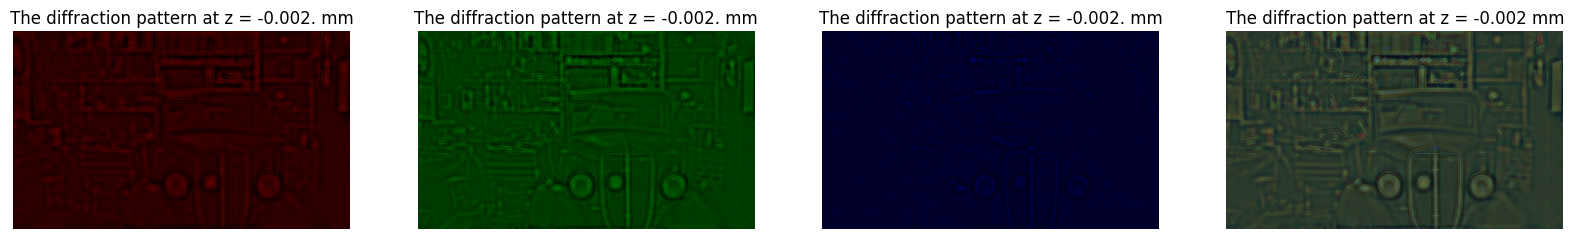

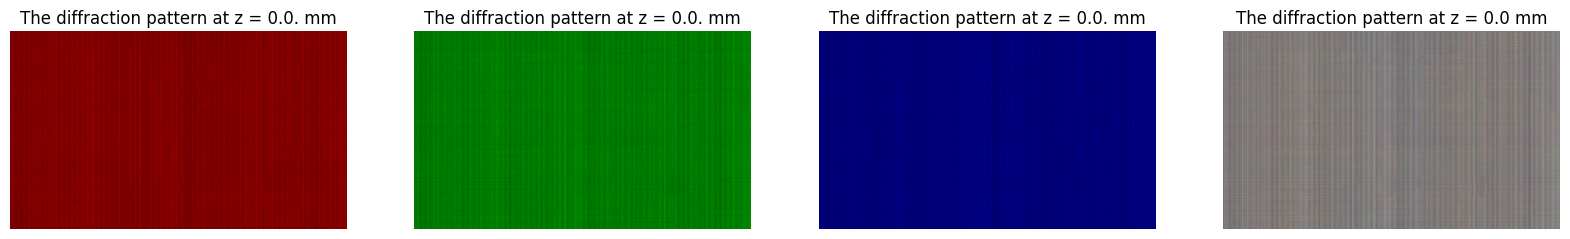

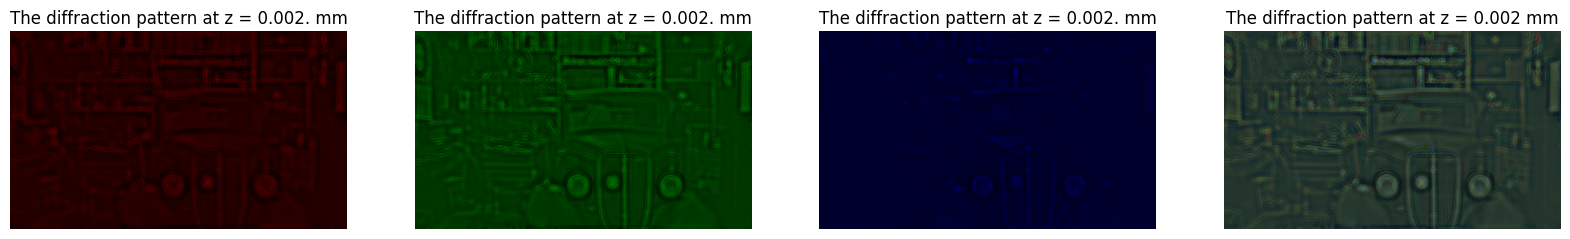

In [1]:
import torch
import utilities
from band_limited_angular_spectrum_method import bandLimitedAngularSpectrumMethod

distances = torch.Tensor([-2.5e-3, 0, 2.5e-3])

A = bandLimitedAngularSpectrumMethod(distances=distances, debug=False)
g_z_complex = A.band_limited_angular_spectrum_multichannels()
utilities.multi_depth_diffraction_plotter(
    utilities.intensity_calculator(g_z_complex), distances, rgb_img=True
)

In [11]:
freq_x = torch.rand(4)
freq_y = torch.rand(3)
freq_mesh_x_y = freq_x.unsqueeze(1)**2 + freq_y.unsqueeze(0)**2
print(freq_x)
print(freq_y)
print(freq_mesh_x_y)



tensor([0.2218, 0.2008, 0.2059, 0.8848])
tensor([0.0923, 0.9061, 0.5796])
tensor([[0.0577, 0.8702, 0.3852],
        [0.0488, 0.8613, 0.3763],
        [0.0509, 0.8634, 0.3784],
        [0.7913, 1.6038, 1.1188]])


In [2]:
tensorX = torch.rand(4,3,5,6)
print(tensorX)
print(tensorX.size())
print(tensorX.dim())

tensor([[[[0.7191, 0.2492, 0.9825, 0.8306, 0.3124, 0.2788],
          [0.8589, 0.9926, 0.0010, 0.1570, 0.1533, 0.4238],
          [0.4475, 0.6243, 0.8704, 0.5280, 0.6219, 0.7425],
          [0.4030, 0.9924, 0.4807, 0.6051, 0.0338, 0.2813],
          [0.0483, 0.6831, 0.9527, 0.8835, 0.5294, 0.1272]],

         [[0.4827, 0.2232, 0.8766, 0.3966, 0.8468, 0.2513],
          [0.7515, 0.7129, 0.3200, 0.8901, 0.5205, 0.0733],
          [0.6300, 0.1991, 0.8302, 0.5467, 0.5953, 0.2870],
          [0.5827, 0.0407, 0.5584, 0.2962, 0.5116, 0.6977],
          [0.5438, 0.7131, 0.6089, 0.1015, 0.5261, 0.0946]],

         [[0.2936, 0.0947, 0.6810, 0.3123, 0.3541, 0.9513],
          [0.4705, 0.7226, 0.3902, 0.4507, 0.2212, 0.8703],
          [0.7676, 0.6161, 0.1146, 0.9135, 0.5470, 0.3987],
          [0.0667, 0.5013, 0.6225, 0.9414, 0.5508, 0.0686],
          [0.3133, 0.9771, 0.2863, 0.4571, 0.0492, 0.5850]]],


        [[[0.9517, 0.6101, 0.3414, 0.9919, 0.8562, 0.4086],
          [0.6817, 0.4362, 0.157

tensor([[[0.3076, 0.8082, 0.0619, 0.2407, 0.8853, 0.5676],
         [0.3002, 0.2465, 0.5690, 0.0799, 0.0111, 0.0779],
         [0.7944, 0.3455, 0.9801, 0.7547, 0.6982, 0.0057],
         [0.2676, 0.8987, 0.3114, 0.8633, 0.3422, 0.9308],
         [0.9249, 0.6157, 0.8818, 0.4928, 0.2945, 0.1674]],

        [[0.0424, 0.7092, 0.1120, 0.2532, 0.6587, 0.3505],
         [0.6642, 0.9700, 0.5608, 0.6668, 0.8260, 0.5930],
         [0.5998, 0.9822, 0.8112, 0.9482, 0.5915, 0.2278],
         [0.3506, 0.2835, 0.0804, 0.6764, 0.8492, 0.2987],
         [0.7911, 0.2511, 0.9257, 0.0763, 0.6530, 0.8261]],

        [[0.6015, 0.2796, 0.5867, 0.1014, 0.9082, 0.0643],
         [0.1319, 0.6858, 0.8145, 0.1812, 0.9834, 0.2716],
         [0.0971, 0.4076, 0.4227, 0.1407, 0.4682, 0.5553],
         [0.0956, 0.7935, 0.2728, 0.2582, 0.2845, 0.8630],
         [0.7513, 0.5782, 0.2815, 0.6894, 0.4411, 0.5569]]])


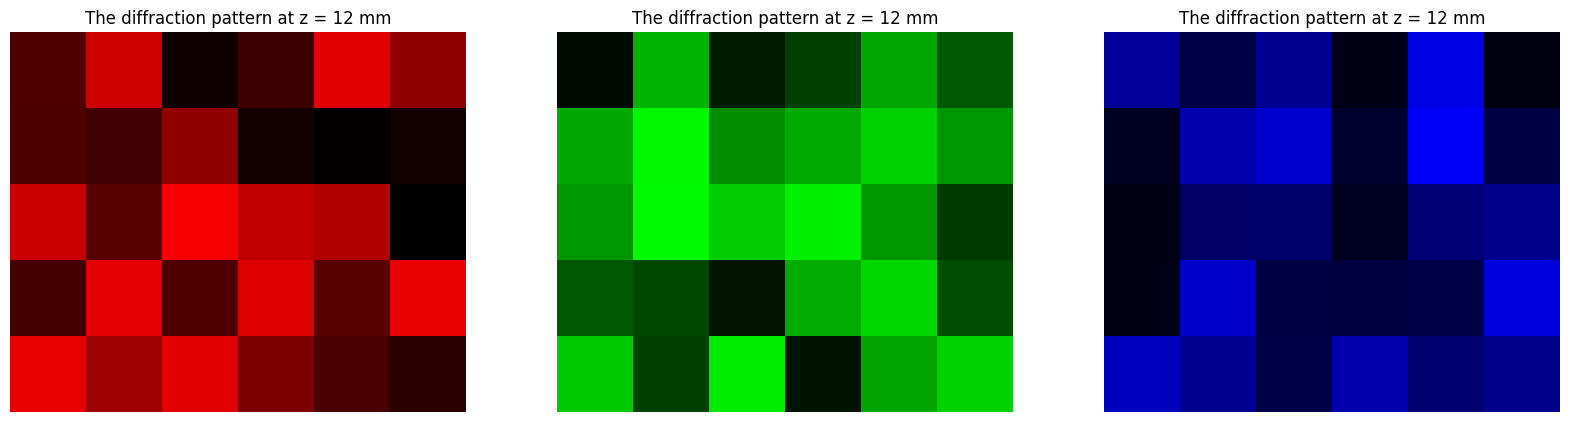

In [9]:
import torch
import utilities
tensorX = torch.rand(3,5,6)
print(tensorX)
utilities.diffraction_plotter(tensorX, 12, False, 0)


In [9]:
freq = torch.fft.fftfreq(9, 1/9)
freq_with_fftshift = torch.fft.fftshift(freq)
freq_with_ifftshift = torch.fft.ifftshift(freq)
print(freq)
print(freq_with_fftshift)
print(freq_with_ifftshift)

tensor([ 0.,  1.,  2.,  3.,  4., -4., -3., -2., -1.])
tensor([-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.])
tensor([ 4., -4., -3., -2., -1.,  0.,  1.,  2.,  3.])


In [14]:
import torch

field_padded = torch.rand(1920,1080).to('cuda')
H =torch.rand(1920,1080).to('cuda')
aperture = torch.rand(1920,1080).to('cuda')


# original code
U1_1 = torch.fft.fftshift(torch.fft.fft2(torch.fft.fftshift(field_padded)))
U2_1 = H * aperture * U1_1
result_1 = torch.fft.ifftshift(torch.fft.ifft2(torch.fft.ifftshift(U2_1)))


# remove the fftshift and ifftshift in the spatial domain
U1_2 = torch.fft.fftshift(torch.fft.fft2(field_padded))
U2_2 = H * aperture * U1_2
result_2 = torch.fft.ifft2(torch.fft.ifftshift(U2_2))

assert torch.allclose(result_1, result_2, atol=1e-6)

In [2]:
import time
import torch

def cpu_timer(operation,reapeat=100):
    total_time = 0
    for _ in range(reapeat):
        start_time = time.perf_counter()
        operation()
        end_time = time.perf_counter()
        total_time += end_time - start_time
    return total_time/reapeat

def gpu_timer(operation,reapeat=100):
    total_time = 0
    # clean the cache on gpu
    torch.cuda.empty_cache()
    for _ in range(reapeat):
        torch.cuda.synchronize()
        start_time = torch.cuda.Event(enable_timing=True)
        end_time = torch.cuda.Event(enable_timing=True)
        
        start_time.record()
        operation()
        end_time.record()
        
        torch.cuda.synchronize()
        total_time += start_time.elapsed_time(end_time)
    return total_time/reapeat

def original_code(field_padded, H, aperture):
    U1 = torch.fft.fftshift(torch.fft.fft2(torch.fft.fftshift(field_padded)))
    U2 = H * aperture * U1
    return torch.fft.ifftshift(torch.fft.ifft2(torch.fft.ifftshift(U2)))

def modified_code(field_padded, H, aperture):
    U1 = torch.fft.fftshift(torch.fft.fft2(field_padded))
    U2 = H * aperture * U1
    return torch.fft.ifft2(torch.fft.ifftshift(U2))

# comparison on cpu
field_padded = torch.rand(1920,1080)
H =torch.rand(1920,1080)
aperture = torch.rand(1920,1080)

original_time = cpu_timer(lambda: original_code(field_padded, H, aperture))
modified_time = cpu_timer(lambda: modified_code(field_padded, H, aperture))
print(f'Original code on CPU: {original_time:.8f} ms')
print(f'Modified code on CPU: {modified_time:.8f} ms')

# check if the results are the same
assert torch.allclose(original_code(field_padded, H, aperture), modified_code(field_padded, H, aperture), atol=1e-6)

# comparison on gpu
field_padded = field_padded.to('cuda')
H = H.to('cuda')
aperture = aperture.to('cuda')

original_time = gpu_timer(lambda: original_code(field_padded, H, aperture))
modified_time = gpu_timer(lambda: modified_code(field_padded, H, aperture))
print(f'Original code on GPU: {original_time:.8f} ms')
print(f'Modified code on GPU: {modified_time:.8f} ms')

# check if the results are the same
assert torch.allclose(original_code(field_padded, H, aperture), modified_code(field_padded, H, aperture), atol=1e-6)

Original code on CPU: 0.03265293 ms
Modified code on CPU: 0.02521489 ms
Original code on GPU: 8.60004100 ms
Modified code on GPU: 5.47566400 ms


In [17]:
%timeit
# original code
U1_1 = torch.fft.fftshift(torch.fft.fft2(torch.fft.fftshift(field_padded)))
U2_1 = H * aperture * U1_1
result_1 = torch.fft.ifftshift(torch.fft.ifft2(torch.fft.ifftshift(U2_1)))

# print the time
%timeit torch.fft.fftshift(torch.fft.fft2(torch.fft.fftshift(field_padded)))
%timeit torch.fft.fftshift(torch.fft.fft2(field_padded))

2.45 ms ± 152 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
2.35 ms ± 49.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


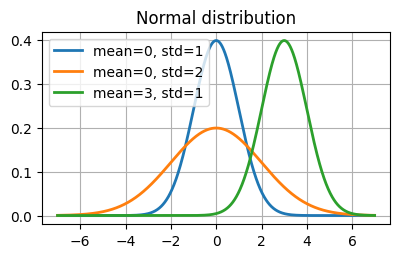

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import math


def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 * (x - mu) ** 2 / sigma**2)


# Use NumPy again for visualization
x = np.arange(-7, 7, 0.01)

# Mean and standard deviation pairs
params = [(0, 1), (0, 2), (3, 1)]
plt.figure(figsize=(4.5, 2.5))
plt.plot(x,normal(x, *params[0]), linewidth=2, label='mean=0, std=1')
plt.plot(x,normal(x, *params[1]), linewidth=2, label='mean=0, std=2')
plt.plot(x,normal(x, *params[2]), linewidth=2, label='mean=3, std=1')
plt.legend()
plt.title('Normal distribution')
plt.grid()
plt.show()

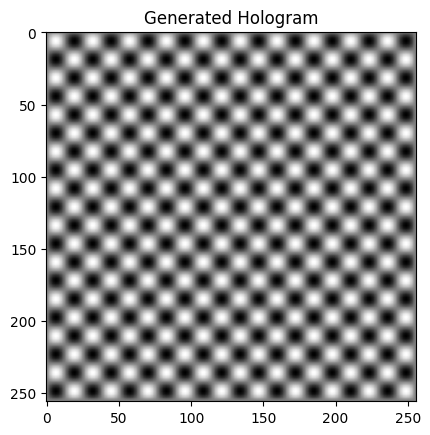

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# 生成一个简单的二维全息图（正弦波干涉图样）
def generate_hologram(size, frequency):
    x = np.linspace(-np.pi, np.pi, size)
    y = np.linspace(-np.pi, np.pi, size)
    X, Y = np.meshgrid(x, y)
    hologram = np.sin(frequency * X) * np.sin(frequency * Y)
    return hologram

size = 256
frequency = 10
hologram = generate_hologram(size, frequency)

plt.imshow(hologram, cmap='gray')
plt.title("Generated Hologram")
plt.show()


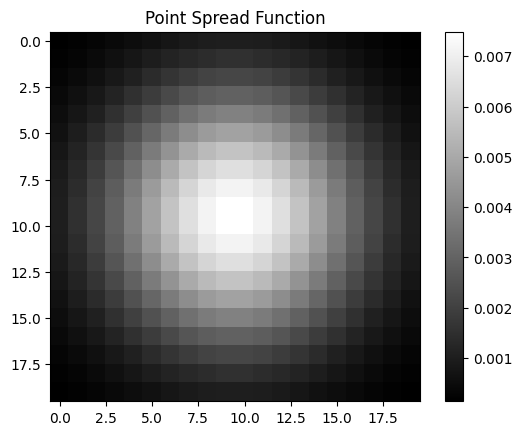

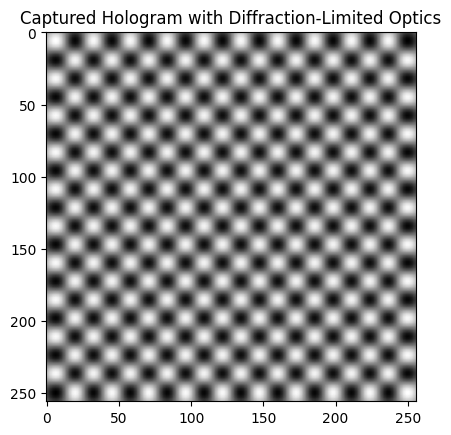

In [11]:
from scipy.signal import convolve2d

# 生成理想的点扩散函数（高斯函数模拟）
def gaussian_psf(size, sigma):
    x = np.linspace(-size // 2, size // 2, size)
    y = np.linspace(-size // 2, size // 2, size)
    X, Y = np.meshgrid(x, y)
    psf = np.exp(-(X**2 + Y**2) / (2 * sigma**2))
    psf /= np.sum(psf)
    return psf

psf_size = 20
sigma = 5  # 模拟数值孔径和波长的影响
psf = gaussian_psf(psf_size, sigma)

# plot the point spread function
plt.imshow(psf, cmap='gray')
plt.title("Point Spread Function")
plt.colorbar()
plt.show()

# 模拟相机对全息图的拍摄过程（卷积操作）
captured_hologram = convolve2d(hologram, psf, mode='same')

plt.imshow(captured_hologram, cmap='gray')
plt.title("Captured Hologram with Diffraction-Limited Optics")
plt.show()


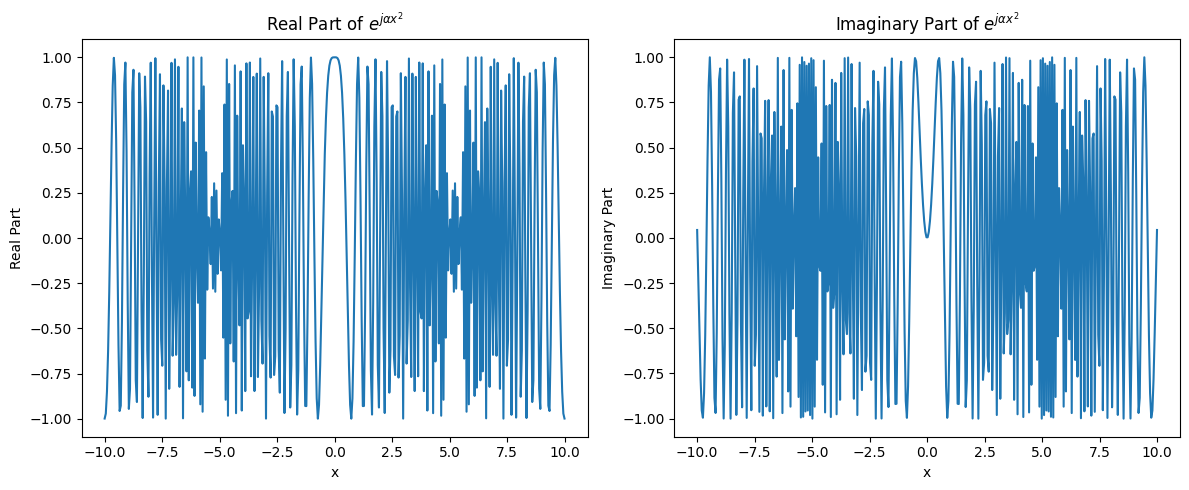

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# 定义参数
alpha = 6.0
x = np.linspace(-10, 10, 400)

# 计算二次相位指数函数
quadratic_phase = np.exp(1j * alpha * x**2)

# 分别绘制实部和虚部
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(x, np.real(quadratic_phase))
plt.title('Real Part of $e^{j \\alpha x^2}$')
plt.xlabel('x')
plt.ylabel('Real Part')

plt.subplot(1, 2, 2)
plt.plot(x, np.imag(quadratic_phase))
plt.title('Imaginary Part of $e^{j \\alpha x^2}$')
plt.xlabel('x')
plt.ylabel('Imaginary Part')

plt.tight_layout()
plt.show()


In [3]:
def num_gpus():  #@save
    """Get the number of available GPUs."""
    return torch.cuda.device_count()

num_gpus()

1

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

print(torch.cuda.is_available())

# 检查是否有 GPU 可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 生成一些示例数据
x_train = torch.randn(100, 10)
y_train = torch.randn(100, 1)

# 创建数据集和数据加载器
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 定义一个简单的神经网络模型
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(10, 50)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# 实例化模型并移动到 GPU
model = SimpleNN().to(device)

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# 训练模型
num_epochs = 20
for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        # 将数据移动到 GPU
        inputs, targets = inputs.to(device), targets.to(device)
        
        # 前向传播
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


True
Epoch [1/20], Loss: 0.6930
Epoch [2/20], Loss: 0.7139
Epoch [3/20], Loss: 0.6595
Epoch [4/20], Loss: 0.5928
Epoch [5/20], Loss: 0.7514
Epoch [6/20], Loss: 0.7275
Epoch [7/20], Loss: 1.1080
Epoch [8/20], Loss: 0.6986
Epoch [9/20], Loss: 0.8675
Epoch [10/20], Loss: 1.3716
Epoch [11/20], Loss: 1.7587
Epoch [12/20], Loss: 0.0790
Epoch [13/20], Loss: 1.4774
Epoch [14/20], Loss: 0.2219
Epoch [15/20], Loss: 0.5333
Epoch [16/20], Loss: 0.3532
Epoch [17/20], Loss: 0.4076
Epoch [18/20], Loss: 1.4228
Epoch [19/20], Loss: 0.4489
Epoch [20/20], Loss: 0.6263


In [21]:
def angular_spectrum(
    source_plain=-1,
    amplitude_plain=-1,
    phase_plain=-1,
    wave_length=1,
    pixel_pitch = 3.74e-6,
    z=100 * 2048, # the propagation distance
    sample_u=1024,  # the number of pixels in x-axis
    sample_v=1024,  # the number of pixels in y-axis
    clipper_u=-1,
    clipper_v=-1,
):
    dx = 2 * pixel_pitch  # the sample interval

    N_u = 2 * sample_u
    N_v = 2 * sample_v


    # generate the 2-D frequency mesh
    freq_x = torch.fft.fftfreq(N_u, dx)
    freq_y = torch.fft.fftfreq(N_v, dx)

    freq_x = torch.unsqueeze(freq_x, dim=1).expand(
        -1, len(freq_y)
    )  # expand to len(y) columns
    freq_y = torch.unsqueeze(freq_y, dim=0).expand(
        len(freq_x), -1
    )  # expand to len(x) rows
    freq_square = freq_x**2 + freq_y**2

    freq_squre_max = torch.full((N_u, N_v), 1 / wave_length) ** 2
    w_square_0 = freq_squre_max - freq_square
    mask = w_square_0 > 0
    w_square = torch.where(mask, w_square_0, 0)

    # transfer function
    H_FR = torch.empty((N_u, N_v), dtype=torch.complex64)
    H_FR = torch.exp(2j * math.pi * z * torch.sqrt(w_square))

    # generate the source plain
    g_0 = torch.zeros((N_u, N_v))
    if isinstance(source_plain, torch.Tensor):
        # load the picture
        g_0[
            N_u // 2 - sample_u // 2 : N_u // 2 + sample_u // 2,
            N_v // 2 - sample_v // 2 : N_v // 2 + sample_v // 2,
        ] = source_plain
        G_0 = torch.fft.fft2(g_0)
    elif (isinstance(amplitude_plain, torch.Tensor) & isinstance(phase_plain, torch.Tensor)):
        G_0 = amplitude_plain*torch.exp(1j*phase_plain) # generate the source plain in frequency domain
    else:
        print("Error: invalid input")
        return

    # the spectrum in the destination plain
    G_z = G_0 * H_FR


    G_z = torch.fft.fftshift(G_z)
    # clip the frequency in x
    if clipper_u == -1:
        pass
    else:
        G_z[: N_u // 2 + 1 - clipper_u, :] = 0
        G_z[N_u // 2 + clipper_u :, :] = 0

    # clip the frequency in y
    if clipper_v == -1:
        pass
    else:
        G_z[:, : N_v // 2 + 1 - clipper_v] = 0
        G_z[:, N_v // 2 + clipper_v :] = 0

    G_z = torch.fft.ifftshift(G_z)


    # 目标平面
    g_z = torch.fft.ifft2(G_z).abs()

    return (
        H_FR.real,
        g_z[
            int(N_u / 2) - sample_u // 2 : int(N_u / 2) + sample_u // 2,
            int(N_v / 2) - sample_v // 2 : int(N_v / 2) + sample_v // 2,
        ],
    )

In [22]:
def band_limited_angular_spectrum(
    source_plain=-1,
    amplitude_plain=-1,
    phase_plain=-1,
    wave_length=1,
    pixel_pitch=3.74e-6,
    z=100 * 2048,
    sample_u=1024,
    sample_v=1024,
):
    dx = 2 * pixel_pitch  # the sampling interval
    S_x = sample_u * dx
    S_y = sample_v * dx

    N_u = 2 * sample_u
    N_v = 2 * sample_v

    freq_u = torch.fft.fftfreq(N_u, dx)
    freq_u = torch.fft.fftshift(freq_u)

    freq_v = torch.fft.fftfreq(N_v, dx)
    freq_v = torch.fft.fftshift(freq_v)

    d_u = 1 / (2 * S_x)
    d_v = 1 / (2 * S_y)
    u_limit = 1 / (math.sqrt((2 * d_u * z) ** 2 + 1) * wave_length)
    v_limit = 1 / (math.sqrt((2 * d_v * z) ** 2 + 1) * wave_length)

    mask_u = abs(freq_u) <= (u_limit)
    if torch.all(mask_u):
        clipper_u = -1
        max_frequency_retained_u = abs(freq_u[0])
    else:
        first_true_index = torch.argmax(mask_u.to(torch.int))
        clipper_u = N_u // 2 + 1 - first_true_index
        max_frequency_retained_u = abs(freq_u[first_true_index])

    mask_v = abs(freq_v) <= (v_limit)
    if torch.all(mask_v):
        clipper_v = -1
        max_frequency_retained_v = abs(freq_v[0])
    else:
        first_true_index = torch.argmax(mask_v.to(torch.int))
        clipper_v = N_v // 2 + 1 - first_true_index
        max_frequency_retained_v = abs(freq_v[first_true_index])

    H_FR_real, g_z = angular_spectrum(source_plain,amplitude_plain, phase_plain, wave_length, pixel_pitch, z, sample_u, sample_v, clipper_u, clipper_v)

    print(
        f"u: cut-off frequency {(u_limit)} : set clipper_n to be {clipper_u} (the max frequency retained : {max_frequency_retained_u})\n",
        f"v: cut-off frequency {(v_limit)} : set clipper_n to be {clipper_v} (the max frequency retained : {max_frequency_retained_v})\n",
    )

    return max_frequency_retained_u, max_frequency_retained_v, g_z

In [30]:
def phase_image2phase_tensor(image_path):
    image_grey = Image.open(image_path).convert("L") # convert the image to gray scale
    print(image_grey.size)
    transform = transforms.ToTensor()
    image_tensor = transform(image_grey)
    print(image_tensor.shape)
    image_tensor = image_tensor.squeeze(0) # delete a dimension from the tensor
    image_tensor_normalized = image_tensor * 2 * math.pi
    return image_tensor_normalized # return the tensor between 0 and 2*pi
    
phaseTensor = phase_image2phase_tensor("sample_hologram.png")
phaseTensor.shape

(4094, 2400)
torch.Size([1, 2400, 4094])


torch.Size([2400, 4094])

In [31]:
def amplitude_tensor(image_path):
    image_shape = Image.open(image_path).size
    # generate 2-D amplitude tensor same size as the phase tensor all values are 1.0
    amplitude_tensor = torch.ones(image_shape)
    return amplitude_tensor.T
amplitudeTensor = amplitude_tensor("sample_hologram.png")
amplitudeTensor.shape

torch.Size([2400, 4094])

In [36]:
max_frequency_retained_u, max_frequency_retained_v, g_z = band_limited_angular_spectrum(
    source_plain=-1,
    amplitude_plain=amplitude_tensor("sample_hologram.png"),
    phase_plain=phase_image2phase_tensor("sample_hologram.png"),
    wave_length=639e-9,
    pixel_pitch=3.74e-6,
    z=2.5e-3,
    sample_u=2400 // 2,
    sample_v=4094 // 2,
)

(4094, 2400)
torch.Size([1, 2400, 4094])
u: cut-off frequency 1507563.6476508474 : set clipper_n to be -1 (the max frequency retained : 66844.921875)
 v: cut-off frequency 1544493.4391567956 : set clipper_n to be -1 (the max frequency retained : 66844.921875)



(4094, 2400)
torch.Size([1, 2400, 4094])
u: cut-off frequency 1507563.6476508474 : set clipper_n to be -1 (the max frequency retained : 66844.921875)
 v: cut-off frequency 1544493.4391567956 : set clipper_n to be -1 (the max frequency retained : 66844.921875)



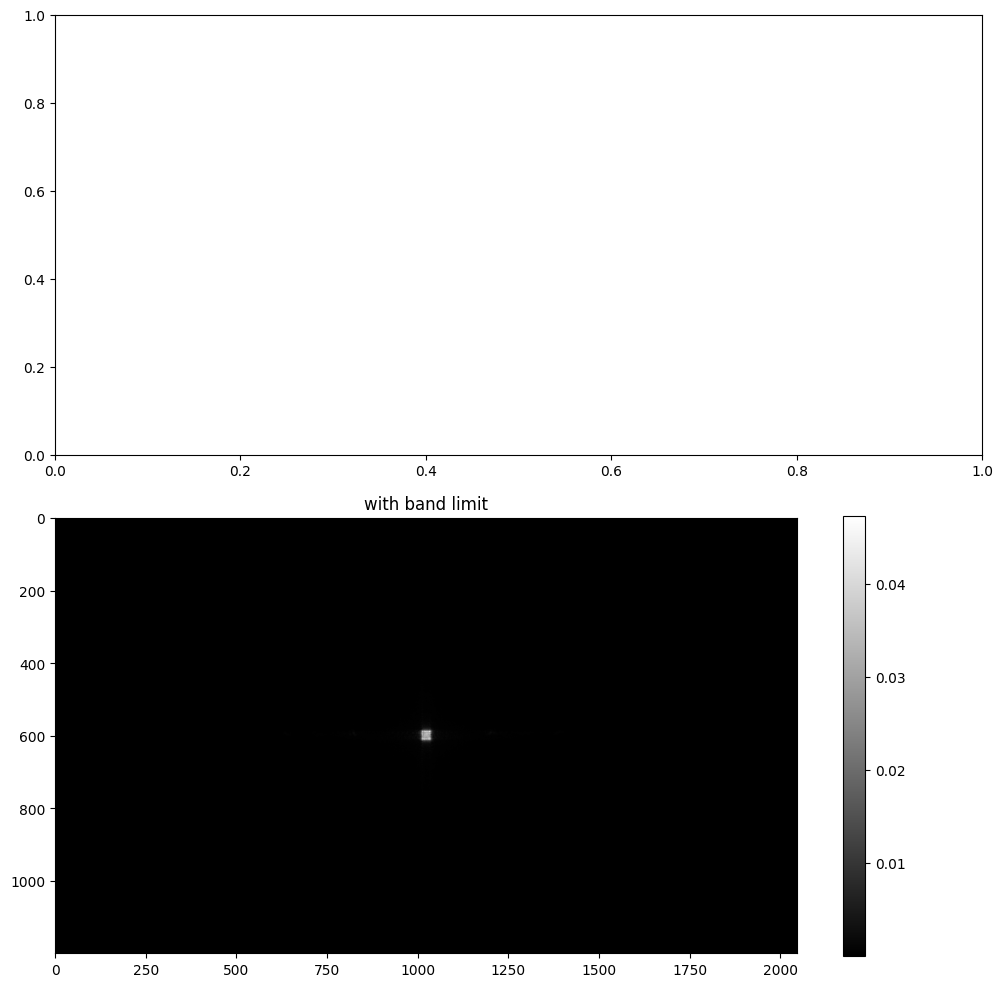

In [37]:
u, v, band_limited_g_z_2D = band_limited_angular_spectrum(
    source_plain=-1,
    amplitude_plain=amplitude_tensor("sample_hologram.png"),
    phase_plain=phase_image2phase_tensor("sample_hologram.png"),
    wave_length=639e-9,
    pixel_pitch=3.74e-6,
    z=2.5e-3,
    sample_u=2400 // 2,
    sample_v=4094 // 2,
)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

# im1 = axes[0].imshow(g_z_2D, cmap="gray")
# fig.colorbar(im1, ax=axes[0])
# axes[0].set_title("original method")

im2 = axes[1].imshow(band_limited_g_z_2D, cmap="gray")
fig.colorbar(im2, ax=axes[1])
axes[1].set_title("with band limit")

plt.tight_layout()
plt.show()